# Quick overview

This tutorial gives a very quick introduction to Eradiate's main features. We assume here that you have successfully installed the package (see [Getting the code](../../../rst/getting_started/building.rst)). In this guide, we will see:

- how to run a simulation using the one-dimensional solver command-line interface;
- how to run the same simulation using Eradiate's Python API.

It is strongly recommended to execute the Python code presented here in a Jupyter notebook.

<div class="alert alert-info">

This tutorial is available as a Jupyter notebook in the Eradiate codebase 
[`$ERADIATE_DIR/resources/data/notebooks/tutorials/quick_overview/quick_overview.ipynb`].

</div>


## Using the command-line

A first entry point to Eradiate is the command-line interface to its solvers. They are directly accessible from a terminal, provided that environment variables are set correctly. For this example, we will use the `ertonedim` application, which works on a one-dimensional scene consisting of a flat surface and an atmosphere. We can first call it with its `--help` flag to display the help text:

In [1]:
!ertonedim --help

Usage: ertonedim [OPTIONS] CONFIG FNAME_RESULTS FNAME_PLOTS

  A simple command-line interface to the OneDimSolverApp class.

  This tool reads a OneDimSolverApp YAML configuration file located at
  CONFIG and simulates radiative transfer on it. It stores the results in
  files named with the prefix FNAME_RESULTS and creates default plots in
  files named with the prefix FNAME_PLOTS.

Options:
  --help  Show this message and exit.


This application is configured with a file which uses the [YAML format](https://yaml.org/). A sample configuration file [`$ERADIATE/resources/data/notebooks/tutorials/quick_overview/config.yml`] is given with this tutorial. Let's first `cd` to the directory where our tutorial files are located:

In [2]:
import os
%cd {os.environ["ERADIATE_DIR"]}/resources/data/notebooks/tutorials/quick_overview

/Users/leroyv/Documents/src/rayference/rtm/eradiate/resources/data/notebooks/tutorials/quick_overview


Now we can visualise the configuration file:

In [3]:
%cat config.yml

mode:
  type: mono
  wavelength: 550.  # nm
surface:
  type: lambertian
  reflectance: 
      type: uniform
      value: 0.5  # dimensionless
atmosphere:
  type: rayleigh_homogeneous
  height: 40.  # km
illumination:
  type: directional
  zenith: 30.  # deg
  azimuth: 0.  # deg
  irradiance: 
      type: uniform
      value: 1.8e+6  # W/km^2/nm
measure:
  - type: toa_lo_hsphere
    spp: 32000  # dimensionless
    zenith_res: 10.  # deg
    azimuth_res: 10.  # deg


The file format is described in **[add link to one-dimensional solver introduction]**.

In addition, `ertonedim` requires the user to specify output and plot filename prefixes. These can be absolute or relative paths.

In [4]:
!ertonedim config.yml ertonedim ertonedim

Saving results to ertonedim_toa_lo_hsphere.nc


The application saves plots and results to the instructed location. 

- Results are saved in the netCDF format and can be further processed using your tools of choice. One netCDF file is created for each measure specified in the configuration file.
- One plot is generated for each measure specified in the configuration file. Note that Eradiate's applications do not allow for plot customisation; should that be done, the Python API should be preferred.

In [5]:
%ls

config.yml                      ertonedim_toa_lo_hsphere.png
ertonedim_toa_brdf_hsphere.png  ipython_config.py@
ertonedim_toa_brf_hsphere.png   quick_overview.ipynb
ertonedim_toa_lo_hsphere.nc


## Using the Python API

Eradiate also provides total access to its features through a complete and documented API (see [API reference](../../../rst/api_reference/intro.rst)). The `ertonedim` command-line tool is a thin wrapper around the [OneDimSolverApp](../../../rst/api_reference/generated/eradiate.solvers.onedim.app.OneDimSolverApp.rst) class. We can easily reproduce the previous computation using it.

We start by loading our YAML configuration file into a dictionary:

In [6]:
import yaml
with open("config.yml") as f:
    config = yaml.safe_load(f)
config

{'mode': {'type': 'mono', 'wavelength': 550.0},
 'surface': {'type': 'lambertian',
  'reflectance': {'type': 'uniform', 'value': 0.5}},
 'atmosphere': {'type': 'rayleigh_homogeneous', 'height': 40.0},
 'illumination': {'type': 'directional',
  'zenith': 30.0,
  'azimuth': 0.0,
  'irradiance': {'type': 'uniform', 'value': 1800000.0}},
 'measure': [{'type': 'toa_lo_hsphere',
   'spp': 32000,
   'zenith_res': 10.0,
   'azimuth_res': 10.0}]}

We can see here that the contents of the configuration file are directly translated into a configuration dictionary. This dictionary can be used as the argument of the `OneDimSolverApp` constructor:

In [7]:
from eradiate.solvers.onedim.app import OneDimSolverApp
solver = OneDimSolverApp(config)

Launching the simulation is then as simple as calling the [OneDimSolverApp.run()](../../../rst/api_reference/generated/eradiate.solvers.onedim.app.OneDimSolverApp.rst#eradiate.solvers.onedim.app.OneDimSolverApp.run) method:

In [8]:
solver.run()

Unlike the command-line interface, a call to `run()` without argument will not create any result or plot files. Instead, results are saved in the solver object's `results` dictionary. In this case, we have a single measure, so `solver.results` contains a single element under the key `"toa_lo_hsphere"` which corresponds to the only meaure defined in the configuration file. This element is an xarray `Dataset`:

In [9]:
ds = solver.results["toa_lo_hsphere"]
ds

<xarray.Dataset>
Dimensions:           (saa: 1, sza: 1, vaa: 36, vza: 9, wavelength: 1)
Coordinates:
  * sza               (sza) float64 30.0
  * saa               (saa) float64 0.0
  * vza               (vza) float64 0.0 10.0 20.0 30.0 40.0 50.0 60.0 70.0 80.0
  * vaa               (vaa) float64 0.0 10.0 20.0 30.0 ... 330.0 340.0 350.0
  * wavelength        (wavelength) float64 550.0
Data variables:
    toa_lo_hsphere    (sza, saa, vza, vaa, wavelength) float64 2.674e+05 ... ...
    irradiance        (sza, saa, wavelength) float64 1.8e+06
    toa_brdf_hsphere  (sza, saa, vza, vaa, wavelength) float64 0.1485 ... 0.1697
    toa_brf_hsphere   (sza, saa, vza, vaa, wavelength) float64 0.04728 ... 0.054
Attributes:
    angle_convention:  eo_scene
    angular_domain:    hsphere

The usual xarray writing facilities can be used to save the results to a netCDF file:

In [10]:
ds.to_netcdf("ertonedim.nc")

Results can then easily be plotted using Eradiate's matplotlib/xarray-based plotting facilities:

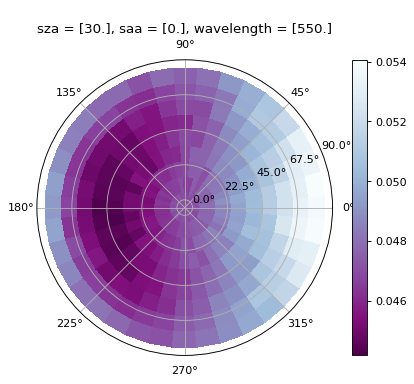

In [11]:
import matplotlib.pyplot as plt
import eradiate.util.view

fig = plt.gcf()
ds.toa_brf_hsphere.ert.plot(kind="polar_pcolormesh")
plt.show()

The figure can be saved using the usual matplotlib pattern:

In [12]:
fig.savefig("ertonedim_toa_brf.png")
plt.close()

From there, any post-processing or customised plotting can happen.

We finish this sequence with a quick cleanup:

In [13]:
%rm ertonedim*.png
%rm ertonedim*.nc